In [1]:
# finetune_sam_mouse_1024_full.py
import os
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm
import torchvision.transforms.functional as TF
import numpy as np
import requests
# ---------- SAM import ----------
try:
    from segment_anything import sam_model_registry
except ImportError:
    raise ImportError("Please install/clone segment-anything: https://github.com/facebookresearch/segment-anything")


In [2]:

# ---------- CONFIG ----------
DATA_FILE = 'dataset_20251005.pt'
IM_SIZE = 1024
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAM_MODEL_VERSION = 'vit_b'
SAM_CHECKPOINT_DIR = Path('./sam_checkpoints')
SAM_CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
SAVE_DIR = Path("./outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Download SAM ----------

CHECKPOINT_URLS = {
    #'vit_b': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth',
    #'vit_l': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_4b8939.pth',
    'vit_h': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth',
}

def download_checkpoint(version: str, save_dir: Path):
    checkpoint_path = save_dir / f"sam_{version}.pth"
    if checkpoint_path.exists():
        print(f"Checkpoint for {version} already exists at {checkpoint_path}")
        return checkpoint_path
    url = CHECKPOINT_URLS[version]
    print(f"Downloading SAM {version} checkpoint...")
    response = requests.get(url)
    response.raise_for_status()
    with open(checkpoint_path, 'wb') as f:
        f.write(response.content)
    print(f"Checkpoint saved to {checkpoint_path}")
    return checkpoint_path

def load_sam(version: str, checkpoint_dir: Path):
    checkpoint_path = download_checkpoint(version, checkpoint_dir)
    sam = sam_model_registry[version](checkpoint=str(checkpoint_path))
    sam.to(DEVICE)
    # Freeze image encoder and prompt encoder
    for p in sam.image_encoder.parameters():
        p.requires_grad = False
    if hasattr(sam, "prompt_encoder"):
        for p in sam.prompt_encoder.parameters():
            p.requires_grad = False
    return sam
sam = load_sam(SAM_MODEL_VERSION, SAM_CHECKPOINT_DIR)
# ---------- Data Augmentations ----------
#def random_cutout(image, label, max_h=50, max_w=50):
#    _, h, w = image.shape
#    cutout_height = random.randint(10, max_h)
#    cutout_width = random.randint(10, max_w)
#    top = random.randint(0, h - cutout_height)
#    left = random.randint(0, w - cutout_width)
#    image[:, top : top + cutout_height, left : left + cutout_width] = 0
#    label[:, top : top + cutout_height, left : left + cutout_width] = 0
#    return image, label
#
#def adjust_brightness(image, label, brightness_factor=0.2):
#    image = TF.adjust_brightness(image, 1 + (random.random() * 2 - 1) * brightness_factor)
#    return image, label
#
#def random_jitter(image, max_jitter=0.1):
#    noise = torch.randn_like(image) * max_jitter
#    image = torch.clamp(image + noise, 0, 1)
#    return image
#
#def motion_blur(image, kernel_size=5, angle=45):
#    C, H, W = image.shape
#    kernel = torch.zeros((kernel_size, kernel_size))
#    center = kernel_size // 2
#    for i in range(kernel_size):
#        kernel[center, i] = 1
#    kernel = kernel / kernel.sum()
#    kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(C, 1, 1, 1)
#    blurred_image = F.conv2d(image.unsqueeze(0), kernel, padding=kernel_size // 2, groups=C)
#    return blurred_image.squeeze(0)
#
# ---------- Dataset ----------
#class facemapdataset(Dataset):
#    def __init__(self, data_file=DATA_FILE, transform=None):
#        super().__init__()
#        self.transform = transform
#        self.data, self.targets = torch.load(data_file)
#
#    def __len__(self):
#        return len(self.data) * 10
#
#    def __getitem__(self, index):
#        base_index = index % len(self.data)
#        aug_type = index // len(self.data)
#        image, label = self.data[base_index].clone(), self.targets[base_index].clone()
#
#        # Convert grayscale -> 3-channel for SAM
#        if image.shape[0] == 1:
#            image = image.repeat(3, 1, 1)
#
#        # Resize to 1024x1024
#        image = TF.resize(image, [IM_SIZE, IM_SIZE])
#        label = TF.resize(label, [IM_SIZE, IM_SIZE])
#
#        # Apply augmentations
#        if self.transform is not None:
#            if aug_type == 1:
#                image = image.flip([2])
#                label = label.flip([2])
#            elif aug_type == 2:
#                angle = random.uniform(-15, 15)
#                image = TF.rotate(image, angle)
#                label = TF.rotate(label, angle)
#            elif aug_type == 3:
#                scale_factor = random.uniform(0.8, 1.5)
#                image = self.zoom(image, scale_factor)
#                label = self.zoom(label, scale_factor)
#            if random.random() < 0.2:
#                image, label = random_cutout(image, label)
#            if random.random() < 0.2:
#                image, label = adjust_brightness(image, label, 0.5)
#            if random.random() < 0.2:
#                image = motion_blur(image)
#            if random.random() < 0.2:
#                image = random_jitter(image)
#
#        return image, label.long()

#    def zoom(self, img, scale_factor):
#        _, h, w = img.shape
#        new_h, new_w = int(h * scale_factor), int(w * scale_factor)
#        img = TF.resize(img, [new_h, new_w])
#        img = TF.center_crop(img, [IM_SIZE, IM_SIZE])
#        return img

# ---------- DataLoaders ----------
#dataset = facemapdataset(transform="flip")
#N = len(dataset)
#train_idx = np.arange(int(0.6 * N))
#val_idx = np.arange(int(0.6 * N), int(0.8 * N))
#test_idx = np.arange(int(0.8 * N), N)

#train_sampler = SubsetRandomSampler(train_idx)
#val_sampler = SubsetRandomSampler(val_idx)
#test_sampler = SubsetRandomSampler(test_idx)
#
#loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
#loader_val = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=False)
#loader_test = DataLoader(dataset, batch_size=1, sampler=test_sampler, drop_last=False)

# ---------- Training ----------
#def train():
#    sam = load_sam(SAM_MODEL_VERSION, SAM_CHECKPOINT_DIR)
#    sam.train()
#
#    emb_channels = {'vit_b':256,'vit_l':384,'vit_h':512}[SAM_MODEL_VERSION]
#    sam._finetune_head = nn.Sequential(
#        nn.Conv2d(emb_channels, 128, kernel_size=3, padding=1),
#        nn.ReLU(),
#        nn.Conv2d(128, NUM_CLASSES, kernel_size=1)
#    ).to(DEVICE)

#    optimizer = optim.AdamW(sam._finetune_head.parameters(), lr=LR, weight_decay=1e-6)

    #for epoch in range(1, EPOCHS+1):
    #    pbar = tqdm(loader_train, desc=f"Epoch {epoch}/{EPOCHS}")
    #    for images, masks in pbar:
    #        images = images.to(DEVICE)
    #        masks = masks.to(DEVICE).long()
    #        masks = masks.squeeze(1)
#
    #        with torch.no_grad():
    #            emb = sam.image_encoder(images)
    #            if isinstance(emb, tuple):
    #                emb = emb[-1]
#
    #        logits = sam._finetune_head(emb)
    #        logits = F.interpolate(logits, size=(IM_SIZE, IM_SIZE), mode='bilinear', align_corners=False)
    #        loss = F.cross_entropy(logits, masks)
#
    #        optimizer.zero_grad()
    #        loss.backward()
    #        optimizer.step()
    #        pbar.set_postfix(loss=loss.item())
#
    #    # Validation
    #    sam.eval()
    #    iou_sum = 0
    #    with torch.no_grad():
    #        for images, masks in loader_val:
    #            images = images.to(DEVICE)
    #            masks_np = masks.squeeze(1).numpy()[0]
    #            emb = sam.image_encoder(images)
    #            if isinstance(emb, tuple):
    #                emb = emb[-1]
    #            logits = sam._finetune_head(emb)
    #            logits = F.interpolate(logits, size=(IM_SIZE, IM_SIZE), mode='bilinear', align_corners=False)
    #            pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
    #            intersection = np.logical_and(pred == 1, masks_np == 1).sum()
    #            union = np.logical_or(pred == 1, masks_np == 1).sum()
    #            iou_sum += intersection / (union + 1e-6)
    #        print(f"[VAL] Epoch {epoch} mean IoU: {iou_sum / len(loader_val)}")
    #    sam.train()
#
    #    torch.save({
    #        "epoch": epoch,
    #        "model_state": sam.state_dict(),
    #        "optimizer_state": optimizer.state_dict()
    #    }, SAVE_DIR / f"sam_mouse_epoch{epoch}.pth")

#if __name__ == "__main__":
#    train()




Checkpoint for vit_b already exists at sam_checkpoints\sam_vit_b.pth


In [ ]:
#from torchvision import models
#import segmentation_models_pytorch as smp  # pip install segmentation-models-pytorch
#
#model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1)


In [3]:
checkpoint_path = SAM_CHECKPOINT_DIR / f"sam_{SAM_MODEL_VERSION}.pth"
sam = sam_model_registry[SAM_MODEL_VERSION](checkpoint=str(checkpoint_path))
sam.to(DEVICE)
sam.eval()

data, targets = torch.load(DATA_FILE)
image = data[0]

image = TF.resize(image, [IM_SIZE, IM_SIZE])
if image.shape[0] == 1:
    image = image.repeat(3, 1, 1)
image = image.to(DEVICE)

with torch.no_grad():
    image_embedding = sam.image_encoder(image.unsqueeze(0))
    if isinstance(image_embedding, tuple):
        image_embedding = image_embedding[-1]

from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(IM_SIZE)
input_point = torch.tensor([[512, 512]])  # center point
input_label = torch.tensor([1])  # foreground
point_coords = transform.apply_coords(input_point.numpy(), image.shape[1:])

from segment_anything import SamPredictor
sam = sam_model_registry[SAM_MODEL_VERSION](checkpoint=str(checkpoint_path))
sam.to(DEVICE)
predictor = SamPredictor(sam)
import numpy as np
image_np = image.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
targets_np = targets[0].permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
predictor.set_image(image_np)
input_point = np.array([[512, 512]])  # center point
input_label = np.array([1])           # foreground
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

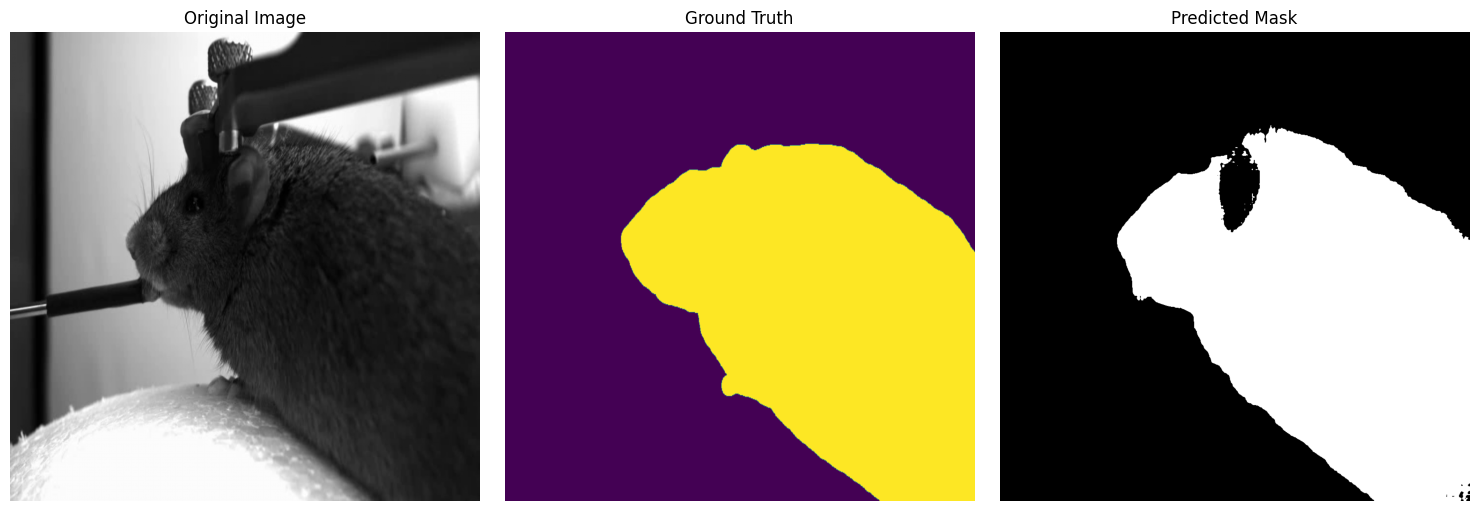

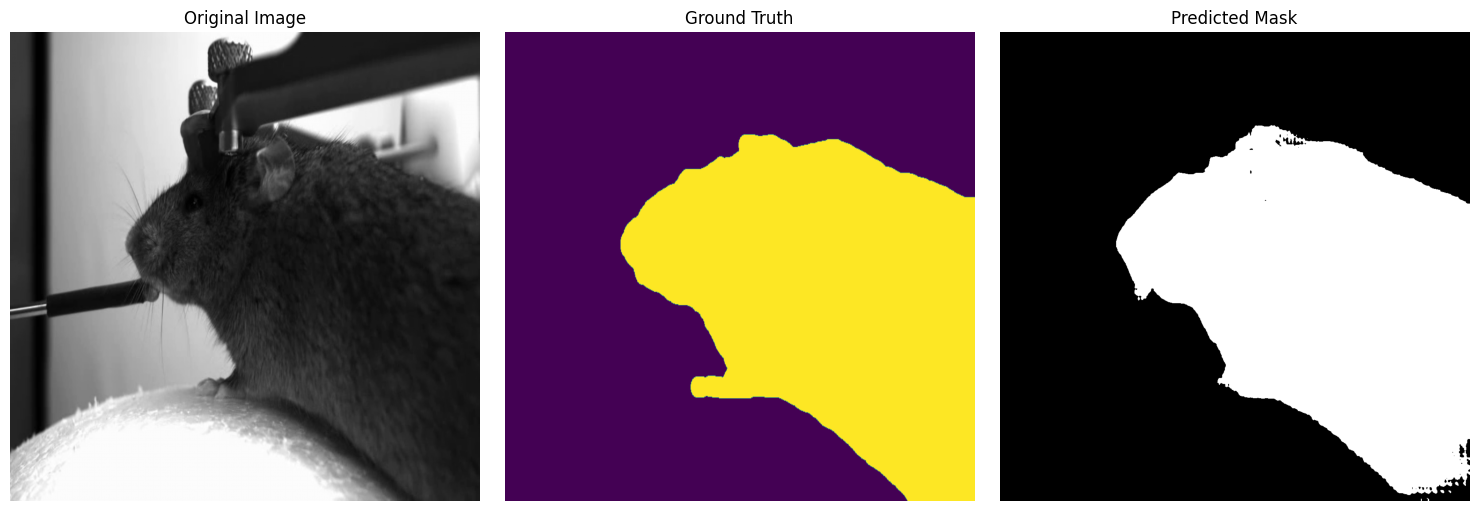

In [4]:
import matplotlib.pyplot as plt

for i in range(2):

    image = TF.resize(data[i], [IM_SIZE, IM_SIZE])
    target = TF.resize(targets[i], [IM_SIZE, IM_SIZE])
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    image = image.to(DEVICE)
    image_np = image.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    targets_np = target.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC


    predictor.set_image(image_np)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # ground truth 
    ax[1].imshow(targets_np)
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    # Predicted mask
    ax[2].imshow(masks[0], cmap='gray')
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import glob
import os
import pdb

# ---------- CONFIG ----------
DATA_FILE = 'dataset_20251005.pt'
IM_SIZE = 1024
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAM_MODEL_VERSION = 'vit_b'
SAM_CHECKPOINT_DIR = Path('./sam_checkpoints')
SAM_CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
SAVE_DIR = Path("./outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
from segment_anything import SamPredictor, sam_model_registry

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from numpy import random
from torch.utils.data import (
    DataLoader,
    Dataset,
    SubsetRandomSampler,
)
from torchvision.utils import save_image

from models import Unet

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#os.chdir(
#    r"C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training_20250909"
#)

# ==========================
# Data augmentation helpers
# ==========================

def random_cutout(image, label, max_h=50, max_w=50):
    _, h, w = image.shape
    cutout_height = random.randint(10, max_h)
    cutout_width = random.randint(10, max_w)
    top = random.randint(0, h - cutout_height)
    left = random.randint(0, w - cutout_width)
    image[:, top:top+cutout_height, left:left+cutout_width] = 0
    label[:, top:top+cutout_height, left:left+cutout_width] = 0
    return image, label


def adjust_brightness(image, label, brightness_factor=0.2):
    image = TF.adjust_brightness(image, 1 + (random.random() * 2 - 1) * brightness_factor)
    return image, label


def random_jitter(image, max_jitter=0.1):
    noise = torch.randn_like(image) * max_jitter
    image = torch.clamp(image + noise, 0, 1)
    return image


def motion_blur(image, kernel_size=5, angle=45):
    kernel = torch.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    for i in range(kernel_size):
        kernel[center, i] = 1
    kernel = kernel / kernel.sum()
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    blurred_image = F.conv2d(image.unsqueeze(0), kernel, padding=kernel_size // 2)
    return blurred_image.squeeze(0)

# ==========================================
# Combined Dataset Class (no saving to disk)
# ==========================================

class facemapdataset(Dataset):
    def __init__(
        self,
        data_files=None,
        data=None,
        targets=None,
        transform=None,
        rotation_degrees=(15, 30),
        zoom_range=(0.8, 1.5),
        blur_radius=(1, 2),
        cutout_prob=0.2,
        brightness_prob=0.2,
        brightness_factor=0.5,
        motion_blur_prob=0.2,
        motion_blur_kernel_size=5,
        motion_blur_angle=45,
        jitter_prob=0.2,
        jitter_max=0.1,
        sam_checkpoint="sam_checkpoints/sam_vit_b.pth",
        im_size = IM_SIZE
    ):
        super().__init__()

        self.transform = transform
        self.rotation_degrees = rotation_degrees
        self.zoom_range = zoom_range
        self.blur_radius = blur_radius
        self.cutout_prob = cutout_prob
        self.brightness_prob = brightness_prob
        self.brightness_factor = brightness_factor
        self.motion_blur_prob = motion_blur_prob
        self.motion_blur_kernel_size = motion_blur_kernel_size
        self.motion_blur_angle = motion_blur_angle
        self.jitter_prob = jitter_prob
        self.jitter_max = jitter_max
        self.im_size = im_size

        # --- Load and combine datasets ---
        if data_files is not None:
            data_list, target_list = [], []
            for file in data_files:
                d, t = torch.load(file)
                data_list.append(d)
                target_list.append(t)
            self.data = torch.cat(data_list, dim=0)
            self.targets = torch.cat(target_list, dim=0)
        else:
            self.data = data
            self.targets = targets

        sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
        sam.to(device)
        self.predictor = SamPredictor(sam)

    def __len__(self):
        return len(self.data) * 10  # number of augmented versions

    def __getitem__(self, index):
        base_index = index % len(self.data)
        aug_type = index // len(self.data)
    
        image, label = self.data[base_index].clone(), self.targets[base_index].clone()
    
        # --- augmentations ---
        if self.transform is not None:
            if aug_type == 1:  # flip
                image = image.flip([2])
                label = label.flip([2])
            elif aug_type == 2:  # rotation
                angle = random.uniform(-self.rotation_degrees[1], self.rotation_degrees[1])
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle)
            elif aug_type == 3:  # zoom
                scale_factor = random.uniform(self.zoom_range[0], self.zoom_range[1])
                image = self.zoom(image, scale_factor)
                label = self.zoom(label, scale_factor)
            elif aug_type == 4:  # blur
                radius = (
                    torch.rand(1).item() * (self.blur_radius[1] - self.blur_radius[0])
                    + self.blur_radius[0]
                )
                image = TF.gaussian_blur(image, kernel_size=int(radius))
    
            if random.random() < self.cutout_prob:
                image, label = random_cutout(image, label)
            if random.random() < self.brightness_prob:
                image, _ = adjust_brightness(image, label, self.brightness_factor)
            if random.random() < self.motion_blur_prob:
                image = motion_blur(image, self.motion_blur_kernel_size, self.motion_blur_angle)
            if random.random() < self.jitter_prob:
                image = random_jitter(image, self.jitter_max)
    
        # --- SAM mask ---
        # Note: keep image grayscale (1 channel) for Unet inCh=2
        image = TF.resize(image, [self.im_size, self.im_size])
        label = TF.resize(label, [self.im_size, self.im_size])
    
        image = image.float() / 255.0 if image.max() > 1 else image
    
        # For SAM: convert grayscale to RGB temporarily
        image_for_sam = image.repeat(3, 1, 1)
        image_np = image_for_sam.permute(1, 2, 0).cpu().numpy()
    
        self.predictor.set_image(image_np)
        input_point = np.array([[self.im_size // 2, self.im_size // 2]])
        input_label = np.array([1])
    
        masks, _, _ = self.predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
    
        sam_mask = torch.tensor(masks[0], dtype=torch.float32).unsqueeze(0)  # [1, H, W]
    
        # Final input to Unet: [2, H, W]  -> [ grayscale , SAM mask ]
        input_tensor = torch.cat([image, sam_mask], dim=0)
        target_tensor = (label > 0).float()
    
        return input_tensor, target_tensor


        #return image, label

    def zoom(self, img, scale_factor):
        _, h, w = img.shape
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)
        img = TF.resize(img, [new_h, new_w])
        img = TF.center_crop(img, [h, w])
        return img


# ==========================================
# Load and combine datasets directly
# ==========================================

dataset = facemapdataset(
    data_files=[
        r"dataset_20251014.pt",
        r"dataset_20251005.pt",
    ],
    transform="flip"
)

# ==========================================
# Training setup (unchanged)
# ==========================================

x = dataset[0][0]
dim = x.shape[-1]
print("Using %d size of images" % dim)

N = len(dataset)
train_sampler = SubsetRandomSampler(np.arange(int(0.6 * N)))
valid_sampler = SubsetRandomSampler(np.arange(int(0.6 * N), int(0.8 * N)))
test_sampler = SubsetRandomSampler(np.arange(int(0.8 * N), N))
batch_size = 4

loss_fun = torch.nn.MSELoss(reduction="sum")

num_train = len(train_sampler)
num_valid = len(valid_sampler)
num_test = len(test_sampler)
print("Num. train = %d, Num. val = %d, Num. test = %d" % (num_train, num_valid, num_test))

loader_train = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, pin_memory=True)
loader_valid = DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size, pin_memory=True)
loader_test = DataLoader(dataset, sampler=test_sampler, batch_size=1, pin_memory=True)

# ==========================================
# Model + Training Loop (same as before)
# ==========================================

model = Unet(inCh=2).to(device)
nParam = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %.2f M" % (nParam / 1e6))

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
minLoss = 1e6
convIter = 0
patience = 100
num_epochs = 200
train_loss, valid_loss = [], []

for epoch in range(num_epochs):
    tr_loss = 0
    for i, (inputs, labels) in enumerate(loader_train):
        inputs, labels = inputs.to(device), labels.to(device)
        scores, _ = model(inputs)
        loss = loss_fun(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader_train)}], Loss: {loss.item():.4f}")

    train_loss.append(tr_loss / (i + 1))

    with torch.no_grad():
        val_loss = 0
        for i, (inputs, labels) in enumerate(loader_valid):
            inputs, labels = inputs.to(device), labels.to(device)
            scores, fmap = model(inputs)
            loss = loss_fun(scores, labels)
            val_loss += loss.item()
        val_loss /= (i + 1)
        valid_loss.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < minLoss:
            convEpoch = epoch
            minLoss = val_loss
            convIter = 0
        else:
            convIter += 1

        if convIter == patience:
            print(f"Converged at epoch {convEpoch+1} with val loss {minLoss:.4f}")
            break

plt.figure()
plt.plot(train_loss, label="Training")
plt.plot(valid_loss, label="Validation")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.pdf")
plt.close()

# ==========================================
# Test evaluation
# ==========================================

with torch.no_grad():
    val_loss = 0
    for i, (inputs, labels) in enumerate(loader_test):
        inputs, labels = inputs.to(device), labels.to(device)
        scores, fmap = model(inputs)
        loss = loss_fun(scores, labels)
        val_loss += loss.item()

        img = inputs.squeeze().cpu().numpy()
        pred = scores.squeeze().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()
        fmap = fmap.mean(1).squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(141); plt.imshow(img, cmap="gray")
        plt.subplot(142); plt.imshow(labels)
        plt.subplot(143); plt.imshow(pred)
        plt.subplot(144); plt.imshow(fmap)
        plt.tight_layout()
        plt.savefig(f"preds/test_{i:03d}.jpg")
        plt.close()

    val_loss /= (i + 1)
    print(f"Test Loss: {val_loss:.4f}")

torch.save(model, "models/best_model_complete.pth")
torch.save(model.state_dict(), "model_weights.pth")

Using 1024 size of images
Num. train = 600, Num. val = 200, Num. test = 200
Number of parameters: 0.03 M


c:\Users\soren\Documents\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
x = torch.randn(4, 2, 1024, 1024).to(device)  # batch of 4, 2 channels
model = Unet(inCh=2).to(device)
out, fmap = model(x)   # should work without error